In [2]:
# Francisco Dominguez Mateos
# 01/12/2021
# Kernel dml3.8
# Initial code and auxiliar functions. Don't pay attention to this
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [3]:
# pip install untangle
# The easiest way to parse xml files I have found.
import untangle

In [4]:
# dlib image object detection dataset xml file format
basepath='/home/francisco/datasets/datasets/pictures/indoor_object_detection_dataset/faster_bounding_box_dataset/all'
filename='fireextinguisher.xml'
#filename='exit_fire.xml'
obj=untangle.parse(filename)
len(obj.dataset.images.image)

818

(818, 360, 640, 3)
(360, 640, 3)
(718, 45, 80, 1)
0.0 1.0


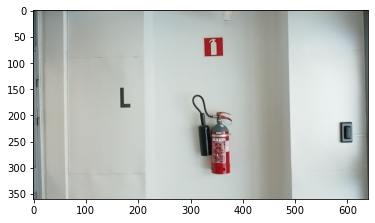

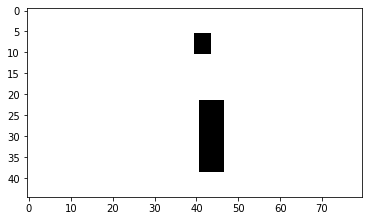

In [5]:
def fillRec(img,x,y,w,h):
    for i in range(w):
        for j in range(h):
            img[y+j,x+i,0]=1
            
def setCenter(img,top,left,width,height):
    center_x=left+width//2
    center_y=top +height//2
    y[center_y,center_x,0]=1
    
images=[]
labels=[]
scale=2
reduction=8
for i in obj.dataset.images.image:#[:818]:
    imgfile=os.path.join(basepath,i['file'])
    img=cv2.imread(imgfile)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    # resize and 
    # normalize very important!!
    img=cv2.resize(img, (img.shape[1]//scale, img.shape[0]//scale))/255.0
    #print(i['file'],'\t',img.shape)
    height_i=img.shape[0]
    width_i =img.shape[1]
    height_o=height_i//reduction
    width_o =width_i //reduction
    y=np.zeros((height_o,width_o,1))
    for b in i.box:
        top   =int(b['top'])   //scale//reduction
        left  =int(b['left'])  //scale//reduction
        width =int(b['width']) //scale//reduction
        height=int(b['height'])//scale//reduction
        
        #setCenter(y,top,left,width,height)
        fillRec(y,left,top,width,height)
        #print("  ",b.label.cdata,"\t->\t[",top,",",left,",",width,",",height,"]")
    images.append(img)
    labels.append(y)
plt.figure()
images_np=np.array(images)
y_train=np.array(labels[:718])
y_test =np.array(labels[718:])
print(images_np.shape)
x_train=images_np[:718]
x_test =images_np[718:]
print(x_train[0].shape)
print(y_train.shape)
print(np.min(y_train),np.max(y_train))
plt.imshow(x_train[0].reshape(height_i,width_i,3))
plt.show()
plt.imshow(y_train[0].reshape(height_o,width_o),cmap="gray_r")
plt.show()

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Flatten, LeakyReLU
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical
print("tf=",tf.__version__)
print("keras=",keras.__version__)

tf= 2.4.1
keras= 2.4.0


In [9]:
#input_shape=(180,320,3)
# Dynamic Imput size
input_shape=(None,None,3)
model = Sequential()

# Without BatchNormalization the model doesn't seem to learn
# (11/04/2019) actually I hadn't normalized the color images just I had to divide by 255
# (11/04/2019) with dropouts and without BatchNorm learn but slowly
model.add(Conv2D(32, (5,5),padding='same',input_shape=input_shape))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(32, (3, 3),padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(32, (3, 3),padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# receptive field aproximation 8(reduction)x3(convolution size)=24
#model.add(Conv2D(1, 3, 3, activation='sigmoid',border_mode='same'))
# receptive field aproximation 8(reduction)x5(convolution size)=40
model.add(Conv2D(32, (5, 5),padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())

# Last layer n filters = n outputs
model.add(Conv2D(1, (3, 3), activation='sigmoid',padding='same'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, None, None, 32)    2432      
_________________________________________________________________
batch_normalization_4 (Batch (None, None, None, 32)    128       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, None, None, 32)    0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
dropout_3 (Dropout)          (None, None, None, 32)    0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 32)    9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, None, None, 32)   

In [10]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [1]:
batch_size=10
epochs=25
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test,y_test),
                    verbose=1)

NameError: name 'model' is not defined

In [39]:
score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train loss: 0.1530781090259552
Train accuracy: 0.9716004133224487
Test loss: 0.041471850126981735
Test accuracy: 0.992920458316803


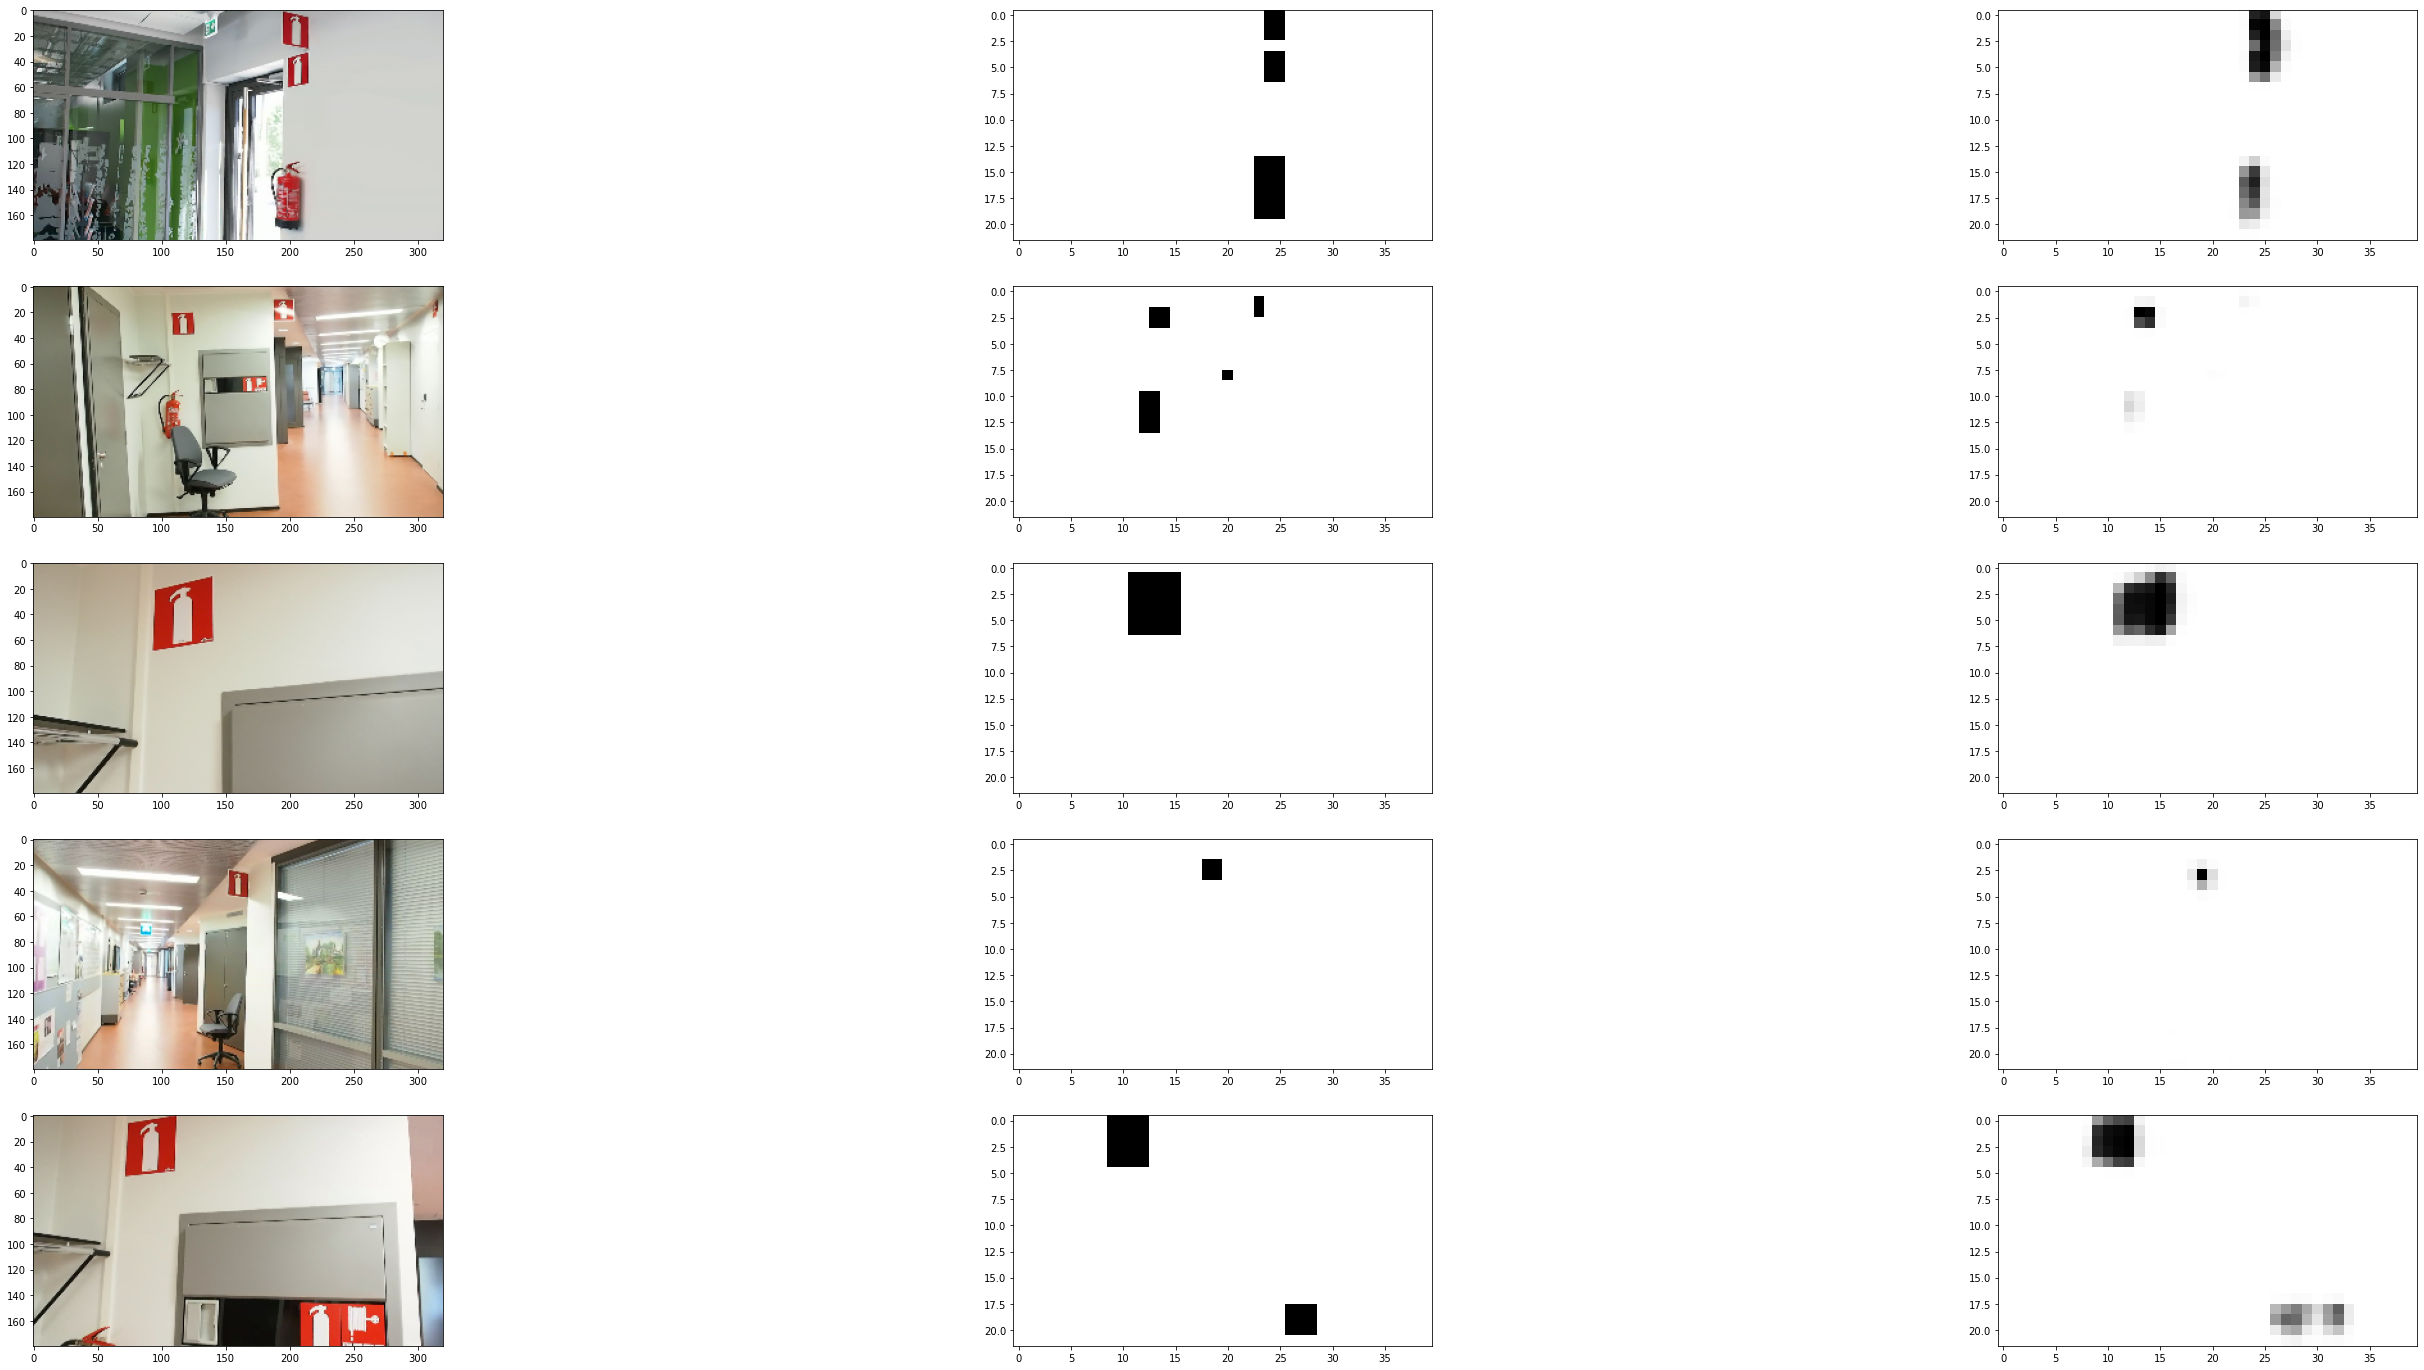

In [45]:
plt.figure(1,figsize=(50,50))
y_pred=model.predict(x_train)
y_dif=np.abs(y_pred-y_train)
for i in range(5):
    idx=random.randint(0,718)
    #print(np.max(y_pred[idx]))
    #print(np.sum(y_dif[idx]/(height_o*width_o)))
    plt.subplot(10, 3, i*3+1)
    plt.imshow(x_train[idx].reshape(height_i,width_i,3))
    #plt.show()
    plt.subplot(10, 3, i*3+2)
    plt.imshow(y_train[idx].reshape(height_o,width_o),cmap="gray_r")
    #plt.show()
    plt.subplot(10, 3, i*3+3)
    plt.imshow(y_pred[idx].reshape(height_o,width_o),cmap="gray_r")
    #plt.show()
    #plt.imshow(y_dif[idx].reshape(height_o,width_o),cmap="gray_r")
plt.show()

TEST
(100, 180, 320, 3)
0.03681996


IndexError: index 100 is out of bounds for axis 0 with size 100

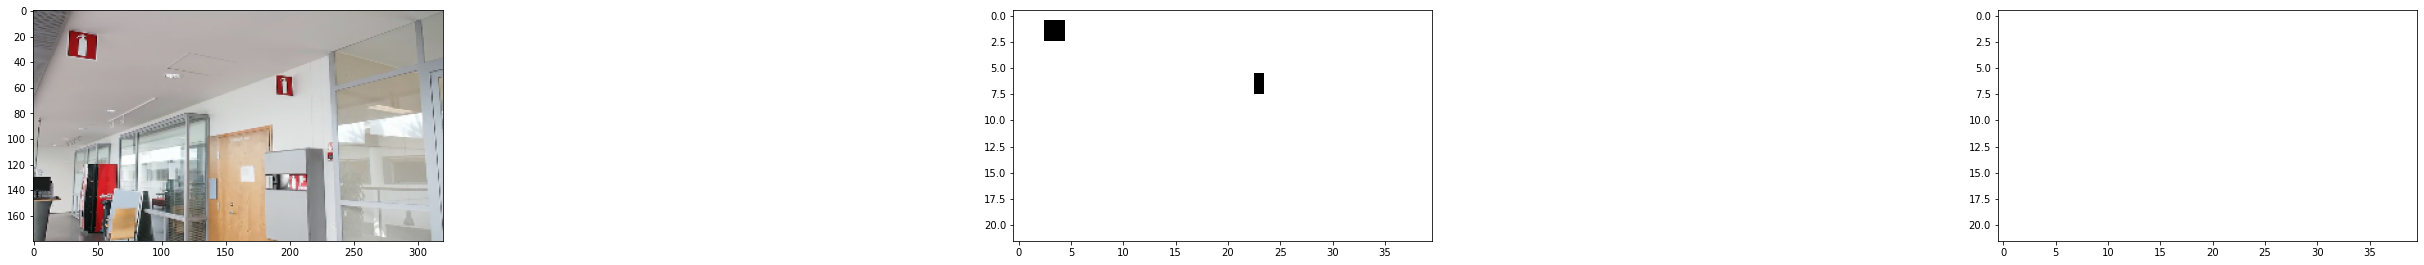

In [41]:
print("TEST")
print(x_test.shape)
plt.figure(1,figsize=(50,50))
y_predf=model.predict(x_test)
y_pred=y_predf>0.5
y_dif=np.abs(y_predf-y_test)
for i in range(5):
    idx=random.randint(0,x_test.shape[0])
    print(np.max(y_predf[idx]))
    #print(np.sum(y_dif[idx]/(height_o*width_o)))
    plt.subplot(10, 3, i*3+1)
    plt.imshow(x_test[idx].reshape(height_i,width_i,3))
    #plt.show()
    plt.subplot(10, 3, i*3+2)
    plt.imshow(y_test[idx].reshape(height_o,width_o),cmap="gray_r")
    #plt.show()
    plt.subplot(10, 3, i*3+3)
    plt.imshow(y_pred[idx].reshape(height_o,width_o),cmap="gray_r")
    #plt.show()
    #plt.imshow(y_dif[idx].reshape(height_o,width_o),cmap="gray_r")
    #plt.show()
plt.show()